In [1]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
import importlib


from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair

from ATARI.ModelData.experimental_model import Experimental_Model

from copy import copy


In [2]:
%matplotlib widget

## Measurement Data

The following measurement data are imported from the work of Jesse Brown at RPI (currently at ORNL).
These measurements are detailed in https://www.tandfonline.com/doi/full/10.1080/00295639.2023.2249786 and consist of 6 experimental configurations.
Of the 4 transmission measurements only 3 are used for evaluation and the 4th (45m FP) is used for validation. 
Both 2 capture measurements are used in evaluation.

The transmission data are reliable in the range 0.15-100 keV.
The capture data are reliable from 0.15-200 keV. 



In [3]:
### Determine channel widths
from ATARI.theory.experimental import e_to_t, t_to_e

def get_chw_and_upperE(E, FP):
    E = np.array(E)
    tof = e_to_t(E, FP, True)
    dt = np.diff(tof*1e6)
    widths1, index1 = np.unique(np.round(dt, 4), return_index=True)
    chw, Emax = np.flipud(widths1), np.flipud(E[index1])
    strc = ''
    stre = ''
    for c,e in zip(chw, Emax):
        strc += f"{c*1e3:.2f}, "
        stre += f"{e:.2f}, "
    return stre, strc

# Emax, chw = get_chw_and_upperE(transdat6.E, 100.14)
# Emax, chw = get_chw_and_upperE(capdat1.E, 45.27)
# print(Emax)
# print(chw)

energy_range_all = [200, 250]

In [4]:
### 1mm capture data
capdat1 = sammy_functions.readlst("./yield_ta1b_unsmooth.dat")
expcap1 = Experimental_Model(title = "cap1mm",
                                reaction ="capture", 
                                energy_range = energy_range_all,
                                n = (0.005631, 0),
                                FP = (45.27, 0.05),
                                burst= (8.0,1.0), 
                                temp= (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [68.20,  122.68, 330.48, 547.57, 199359.52], 
                                    "chw":  [821.40, 410.70, 102.70, 51.30,  25.70],
                                    "dchw": [0.8,    0.8,    0.8,    0.8,    0.8]
                                }
                               )
capdat1 = capdat1.loc[(capdat1.E<max(expcap1.energy_range)) & (capdat1.E>min(expcap1.energy_range)), :]


### 2mm capture data
capdat2 = sammy_functions.readlst("./yield_ta2_unsmooth.dat")
expcap2 = Experimental_Model(   title = "cap2mm",
                                reaction = "capture", 
                                energy_range = energy_range_all,
                                n = (0.011179, 0.0),
                                FP = (45.27, 0.05),
                                burst = (8.0,1.0),
                                temp = (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [68.20,  122.68, 330.48, 547.57, 199359.52], 
                                    "chw":  [821.40, 410.70, 102.70, 51.30,  25.70],
                                    "dchw": [0.8,    0.8,    0.8,    0.8,    0.8]
                                }
                               )
capdat2 = capdat2.loc[(capdat2.E<max(expcap2.energy_range)) & (capdat2.E>min(expcap2.energy_range)), :]


### 1mm Transmission data
transdat1 = sammy_functions.readlst("./trans-Ta-1mm.twenty")
transdat1_covfile = './trans-Ta-1mm.idc'
chw, Emax = get_chw_and_upperE(transdat1.E, 100.14)
exptrans1 = Experimental_Model(title = "trans1mm",
                               reaction = "transmission", 
                               energy_range = energy_range_all,

                                n = (0.00566,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat1 = transdat1.loc[(transdat1.E<max(exptrans1.energy_range)) & (transdat1.E>min(exptrans1.energy_range)), :]

### 3mm transmission data
transdat3 = sammy_functions.readlst("./trans-Ta-3mm.twenty")
transdat3_covfile = "./trans-Ta-3mm.idc"
exptrans3 = Experimental_Model(title = "trans3mm",
                               reaction = "transmission", 
                               energy_range = energy_range_all,

                                n = (0.017131,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat3 = transdat3.loc[(transdat3.E<max(exptrans3.energy_range)) & (transdat3.E>min(exptrans3.energy_range)), :]


### 6mm transmission data
transdat6 = sammy_functions.readlst("./trans-Ta-6mm.twenty")
transdat6_covfile = "./trans-Ta-6mm.idc"
exptrans6 = Experimental_Model(title = "trans6mm",
                               reaction = "transmission", 
                               energy_range = energy_range_all,

                                n = (0.03356,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat6 = transdat6.loc[(transdat6.E<max(exptrans6.energy_range)) & (transdat6.E>min(exptrans6.energy_range)), :]


### Not using 12mm measurement for evaluation - this is a validation measurement

# transdat12 = sammy_functions.readlst("/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-12mm.dat")
# # transdat12_covfile = Need to generate from sys and stat covariances
# exptrans12 = Experimental_Model(title = "trans12",
#                                 reaction = "transmission",
#                                 energy_range = erange_all,

#                                 sammy_inputs = {
#                                     'alphanumeric'       :   ["BROADENING IS WANTED"],
#                                     'ResFunc'            :   "ORRES"
#                                         },

#                                 n = (0.067166, 0.0),  
#                                 FP = (35.185,0.0), 
#                                 burst = (8,0.0), 
#                                 temp = (294.2610, 0.0),

#                                 channel_widths={
#                                         "maxE": [270], 
#                                         "chw": [102.7],
#                                         "dchw": [0.8]
#                                         },

#                                 additional_resfunc_lines=["WATER 0004 5.6822000 -0.54425 0.07733000", "WATER      0.5000000  0.05000 0.00700000", "LITHI 000  -1.000000  -1.0000 6.00000000", "LITHI      0.1000000  0.10000 0.60000000", "LITHI      166.87839 -28.7093 1.260690", "LITHI      0.2574580 -0.06871 0.004915"]
#                                )

# transdat12 = transdat12[(transdat12.E<max(exptrans12.energy_range)) & (transdat12.E>min(exptrans12.energy_range))]


In [5]:
### plotting function
def plot(datasets, experiments, fits=[], priors=[], true=[]):
    colors = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

    for i, exp in enumerate(experiments):
        if exp.reaction == "transmission":
            model_key = "theo_trans"
            iax = 0
        elif exp.reaction == "capture":
            model_key = "theo_xs"
            iax = 1
        else:
            raise ValueError()

        axes[iax].errorbar(datasets[i].E, datasets[i].exp, yerr=datasets[i].exp_unc, zorder=0,
                                                fmt='.', color=colors[i], linewidth=0.5, markersize=1.5, capsize=1, label=exp.title)
        
        if len(fits) != 0:
            axes[iax].plot(fits[i].E, fits[i][model_key], color=colors[i], lw=1.5, label=f'fit {exp.title}')

        if len(priors) != 0:
            axes[iax].plot(priors[i].E, priors[i][model_key], '--', color=colors[i], lw=1.5) #, label=f'prior {exp.title}')
        if len(true) != 0:
            axes[iax].plot(true[i].E, true[i][model_key], '-', color=colors[i], alpha=0.5, lw=1.5) #, label=f'prior {exp.title}')

        
    axes[0].set_ylabel("T")
    axes[1].set_ylabel(r"$Y_{\gamma}$")

    ### make it pretty
    for ax in axes:

        ax.set_xscale('log')
        ax.set_ylim([-0.1,1.1])
        ax.legend()

    fig.supxlabel('Energy (eV)')
    fig.tight_layout()

    return fig

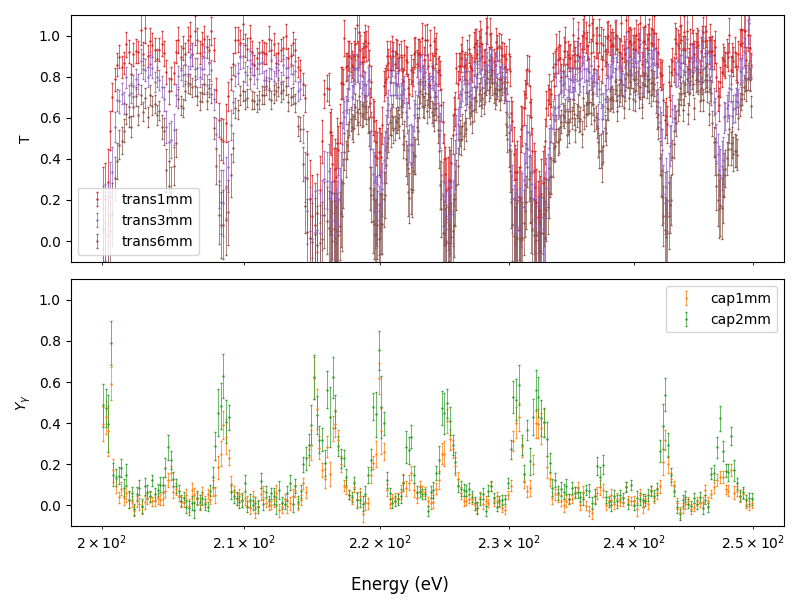

In [6]:
### setup in zipped lists 
datasets = [capdat1, capdat2, transdat1, transdat3, transdat6]
experiments= [expcap1, expcap2, exptrans1, exptrans3, exptrans6]
covariance_data = [{}, {}, transdat1_covfile, transdat3_covfile, transdat6_covfile]
templates = []
for data, exp in zip(datasets, experiments):
    filepath = f'template_{exp.title}_edited'
    exp.template = os.path.realpath(filepath)


fig = plot(datasets, experiments)
fig.tight_layout()

In [7]:
## Could also plot covariance here

In [7]:
sammypath = '/home/fire/SAMMY/sammy/build/install/bin/sammy'

## Fit from ENDF or JEFF

In [8]:
sammyRTO = sammy_classes.SammyRunTimeOptions(#'/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                            sammyexe=sammypath,
                            options= {"Print"   :   True,
                              "bayes"   :   False,
                              "keep_runDIR"     : True
                              })

matnum = 7328

# endf_file = "/Users/noahwalton/research_local/data/neutrons_ENDF-B-VII.1/n-073_Ta_181.endf"
# endf_parameters = sammy_functions.get_endf_parameters(endf_file, matnum, sammyRTO)

# endf_parameters = endf_parameters[(endf_parameters.E<260) & (endf_parameters.E>190)]
# endf_parameters["varyGn1"] = np.ones(len(endf_parameters))
# endf_parameters["varyGg"] = np.ones(len(endf_parameters))*0
# endf_parameters["varyE"] = np.ones(len(endf_parameters))

jeff_file = "/Users/noahwalton/research_local/data/JEFF33_endf6/73-Ta-181g.jeff33"
jeff_file = "./73-Ta-181g.jeff33"
jeff_parameters = sammy_functions.get_endf_parameters(jeff_file, matnum, sammyRTO)

jeff_parameters = jeff_parameters[(jeff_parameters.E<max(energy_range_all)+10) & (jeff_parameters.E>min(energy_range_all)-10)]
jeff_parameters["varyGn1"] = np.ones(len(jeff_parameters))
jeff_parameters["varyGg"] = np.ones(len(jeff_parameters))*0
jeff_parameters["varyE"] = np.ones(len(jeff_parameters))

jeff_parameters

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
46,194.80,55.0000,99.5555,1.0,0.0,1.0,2.0
47,200.00,63.0000,31.4285,1.0,0.0,1.0,1.0
48,204.67,64.9999,2.7540,1.0,0.0,1.0,1.0
49,208.48,64.9999,9.4220,1.0,0.0,1.0,2.0
50,215.09,64.9999,48.2700,1.0,0.0,1.0,2.0
51,216.60,64.9999,19.3900,1.0,0.0,1.0,1.0
52,219.81,64.9999,12.8800,1.0,0.0,1.0,2.0
53,222.29,64.9999,2.4360,1.0,0.0,1.0,2.0
54,225.15,64.9999,20.5700,1.0,0.0,1.0,2.0
55,230.62,64.9999,22.4200,1.0,0.0,1.0,2.0


In [9]:

Ta_pair = Particle_Pair(isotope="Ta181",
                        formalism="XCT",
                        ac=8.1271,     # scattering radius
                        M=180.948030,  # amu of target nucleus
                        m=1,           # amu of incident neutron
                        I=3.5,         # intrinsic spin, positive parity
                        i=0.5,         # intrinsic spin, positive parity
                        l_max=2)       # highest order l-wave to consider

Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D_avg=8.79,
                       Gn_avg=46.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D_avg=4.99,
                       Gn_avg=35.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)


rto = sammy_classes.SammyRunTimeOptions(
    sammyexe=sammypath,
                             options = {"Print"   :   True,
                              "bayes"   :   True,
                              "keep_runDIR"     : True
                              })


sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = jeff_parameters,  

    datasets= datasets,
    experiments = experiments,
    experimental_covariance=covariance_data,  #[{}, {}, {}, {}, {}], # 
    
    max_steps = 10,
    iterations = 2,
    step_threshold = 0.1,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 2,
    LevMarVd= 5,
    initial_parameter_uncertainty = 0.1
    )



In [10]:
# size of the dataset - to compare

# dataset size
sum_points = 0 
for index,el in enumerate(datasets):
    sum_points += el.shape[0]

print(f'Datasets: {len(datasets)}')
print(f'Num of points: {sum_points}')

Datasets: 5
Num of points: 1772


In [11]:
sammyOUT = sammy_functions.run_sammy_YW(sammyINPyw, rto)

Stepping until convergence
chi2 values
step fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum']
0    0.1  : [2.6236, 2.5031, 1.2672, 1.7065, 2.2286, 10.3291]
1    0.2  : [2.105, 2.2448, 0.9129, 1.0776, 1.2233, 7.5636]
2    0.4  : [2.1056, 2.2456, 0.8983, 1.0442, 1.1753, 7.4689]
Chi2 improvement below threshold


In [12]:
# prior_lsts = lsts
print(sammyOUT.chi2n, np.sum(sammyOUT.chi2n))
print(sammyOUT.chi2n_post, np.sum(sammyOUT.chi2n_post))

print(sammyOUT.chi2, np.sum(sammyOUT.chi2))
print(sammyOUT.chi2_post, np.sum(sammyOUT.chi2_post))

[2.62363, 2.50312, 1.26724, 1.70654, 2.22862] 10.329149999999998
[2.10557, 2.24561, 0.89826, 1.04417, 1.17527] 7.46888
[624.425, 595.742, 547.45, 737.225, 962.764] 3467.606
[501.126, 534.454, 388.048, 451.082, 507.717] 2382.427


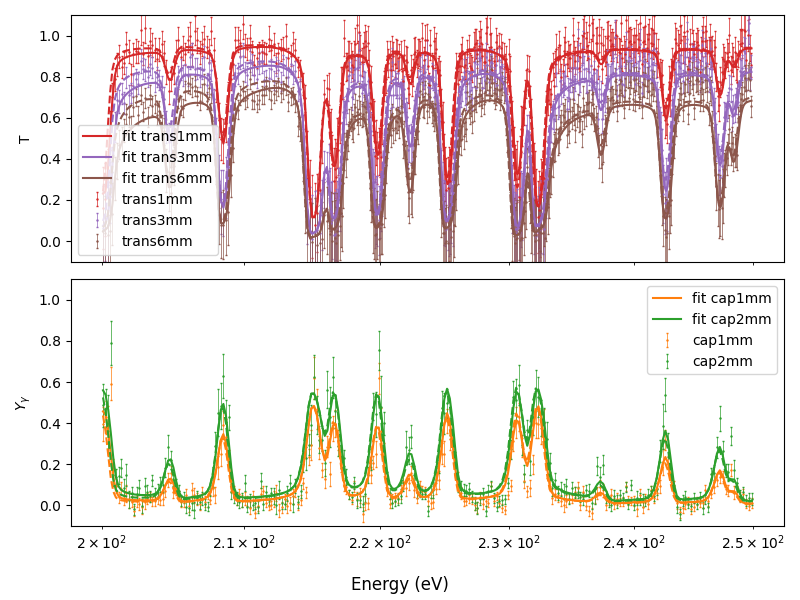

In [13]:
fig = plot(datasets, experiments, fits=sammyOUT.pw_post, priors=sammyOUT.pw)
fig.tight_layout()

In [14]:
sammyOUT.par_post

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
0,195.379961,55.0000,234.255817,1.0,0.0,1.0,2.0
1,200.177266,63.0000,29.240391,1.0,0.0,1.0,1.0
2,204.741871,64.9999,3.125429,1.0,0.0,1.0,1.0
3,208.522557,64.9999,10.324587,1.0,0.0,1.0,2.0
4,215.108373,64.9999,47.553205,1.0,0.0,1.0,2.0
5,216.644595,64.9999,18.562122,1.0,0.0,1.0,1.0
6,219.865588,64.9999,13.254700,1.0,0.0,1.0,2.0
7,222.306543,64.9999,2.987988,1.0,0.0,1.0,2.0
8,225.209002,64.9999,23.160054,1.0,0.0,1.0,2.0
9,230.650295,64.9999,17.853134,1.0,0.0,1.0,2.0


In [15]:
print(sammyOUT.chi2)
print(sum(sammyOUT.chi2))
print(sammyOUT.chi2_post)
print(sum(sammyOUT.chi2_post))

[624.425, 595.742, 547.45, 737.225, 962.764]
3467.606
[501.126, 534.454, 388.048, 451.082, 507.717]
2382.427


In [23]:
# utilizing the autofit

from ATARI.AutoFit.initial_FB_solve import InitialFB, InitialFBOPT

sammy_rto_fit = sammy_classes.SammyRunTimeOptions(
    sammyexe=sammypath,
                             options = {"Print"   :   True,
                              "bayes"   :   True,
                              "keep_runDIR"     : True
                              })


options = InitialFBOPT(Gn_threshold=1e-2,
                       iterations=0)
autofit_initial = InitialFB(options)

In [17]:
outs = autofit_initial.fit(Ta_pair,
                               [200,250],
                               datasets,
                               experiments,
                               covariance_data,
                               sammy_rto_fit)

	FIT 1
Initial solve from 124 resonance features

Stepping until convergence
chi2 values
step fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum']
0    0.5  : [8.0273, 9.8109, 0.2359, 0.4998, 0.6828, 19.2567]
1    0.75 : [7.3602, 8.6456, 0.2111, 0.3883, 0.4759, 17.0811]
2    1.125: [5.3347, 5.8327, 0.1982, 0.3962, 0.6103, 12.3722]
3    1.688: [3.9363, 4.3736, 0.2572, 0.5976, 0.929, 10.0937]
4    2.531: [3.7587, 4.0769, 0.2741, 0.6658, 1.0491, 9.8246]
5    3.797: [3.7944, 4.0833, 0.2662, 0.6394, 1.0111, 9.7944]
Chi2 improvement below threshold

----------------------------------------
Eliminated 3.23% of resonance features based on neuton width
Resolving with 120 resonance features
----------------------------------------

Stepping until convergence
chi2 values
step fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum']
0    0.5  : [3.7935, 4.0792, 0.2663, 0.6402, 1.0117, 9.791]
Repeat step 1, 	fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6

In [16]:
# save initial fit
import pickle


def save_obj_as_pkl(folder_name:str,
                      file_name:str,
                      obj):
    
    try:
        # Ensure the folder exists
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        # Combine folder name and file name for the full path
        full_path = os.path.join(folder_name, file_name)
        
        # Save the figure
        with open(full_path, 'wb') as file:
            pickle.dump(obj, file)
        
        # Return True indicating success
        return True
        
    except Exception as e:
        print(f"Error saving pickle: {e}")
        return False


def load_obj_from_pkl(folder_name: str, pkl_fname: str):
    
    full_path = os.path.join(folder_name, pkl_fname)
    
    # Check if file exists
    if not os.path.exists(full_path):
        print(f"Error: {full_path} does not exist.")
        return None
    
    try:
        with open(full_path, 'rb') as file:
            loaded_obj = pickle.load(file)
        return loaded_obj
    except Exception as e:
        print(f"An error occurred while loading the pickle file: {e}")
        return None
    
save_obj  = save_obj_as_pkl(folder_name='./data/', file_name='Autofit_init_res.pkl', obj = outs)


NameError: name 'outs' is not defined

In [17]:
# reading the prefitted data
outs = load_obj_from_pkl(folder_name='./data/', pkl_fname='Autofit_init_res.pkl')
final_fb_output = outs[-1]

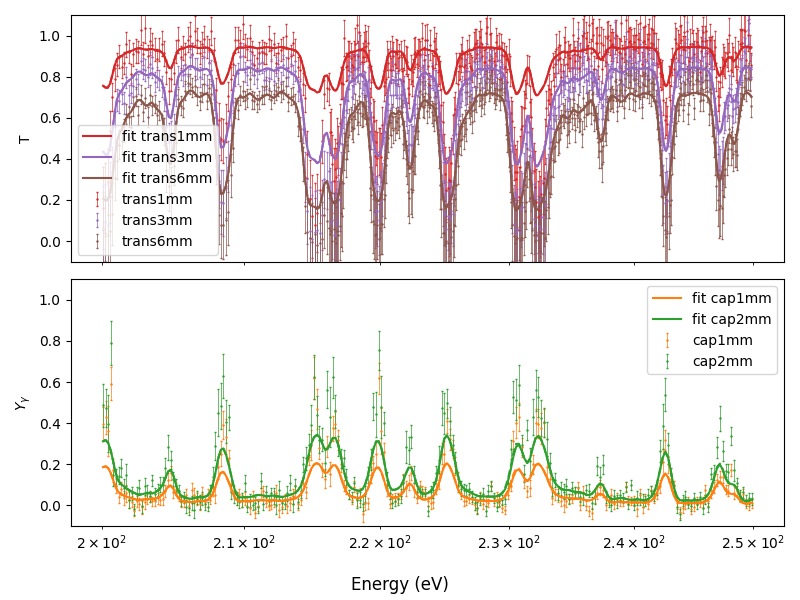

In [18]:
fig = plot(datasets, experiments, fits=final_fb_output.pw_post, priors=final_fb_output.pw)
fig.tight_layout()

In [19]:
print(final_fb_output.chi2)
print(sum(final_fb_output.chi2))
print(final_fb_output.chi2_post)
print(sum(final_fb_output.chi2_post))
print(f'N_res: {final_fb_output.par_post.shape[0]}')

[517.633, 564.456, 154.975, 202.534, 278.365]
1717.963
[515.754, 564.417, 153.693, 201.831, 276.834]
1712.529
N_res: 111


# Resonance elimination 


In [20]:
import importlib
from ATARI.AutoFit import chi2_eliminator_v2
from ATARI.AutoFit import elim_addit_funcs

importlib.reload(chi2_eliminator_v2)
importlib.reload(elim_addit_funcs)

start_ladder = final_fb_output.par_post
assert isinstance(start_ladder, pd.DataFrame)

# side resonances if needed, otherways - keep empty
side_resonances_df = pd.DataFrame()

In [21]:
# # if we do not want to wait hours...

# N = 20

# # just to reduce processing time
# start_ladder = elim_addit_funcs.reduce_ladder(ladder_df=start_ladder,
#                              Gn1_threshold=0.1,
#                              vary_list=[1,1,1],
#                              N=N,
#                              keep_fixed=True,
#                              fixed_side_resonances=side_resonances_df)

# start_ladder


# defining rto & inputs
elim_sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = start_ladder,

    datasets = datasets,
    experimental_covariance=covariance_data,
    experiments = experiments,

    max_steps = 0,
    iterations = 2,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 1.5,

    minF = 1e-5,
    maxF = 10,
    initial_parameter_uncertainty = 0.05
    )

# defining the elim_opts
elim_opts = chi2_eliminator_v2.elim_OPTs(chi2_allowed = 28,
                                         stop_at_chi2_thr = False,
                                      fixed_resonances_df = side_resonances_df,
                                      deep_fit_max_iter = 20,
                                      deep_fit_step_thr = 0.01,
                                      start_fudge_for_deep_stage = 0.05,
                                      )

In [24]:
elimi = chi2_eliminator_v2.eliminator_by_chi2(rto=sammy_rto_fit,
                                            sammyINPyw = elim_sammyINPyw , 
                                            options = elim_opts
                            )

In [25]:
hist = elimi.eliminate(ladder_df= start_ladder)

****************************************
Elimination cycle printout enabled
****************************************

Chi2 thresold applied for model selection: 28


Input ladder:
              E          Gg       Gn1  varyE  varyGg  varyGn1  J_ID
0    199.954174   62.723578  0.249672    1.0     1.0      1.0   1.0
1    200.491586  170.596500  3.707240    1.0     1.0      1.0   1.0
2    201.321955   72.184947  0.419715    1.0     1.0      1.0   1.0
3    201.951486   71.461903  0.339897    1.0     1.0      1.0   1.0
4    203.052392   84.555095  0.184665    1.0     1.0      1.0   1.0
..          ...         ...       ...    ...     ...      ...   ...
106  244.287554   54.570503  0.027783    1.0     1.0      1.0   2.0
107  247.043413   44.398494  0.049775    1.0     1.0      1.0   2.0
108  247.137417   40.972554  1.353130    1.0     1.0      1.0   2.0
109  248.432048   43.318186  0.722323    1.0     1.0      1.0   2.0
110  250.273147   35.890033  0.129391    1.0     1.0      1.0   2.0

[11